# Recurrent Neural Network, 순환 신경망


### RNN 실습, 다음 수 예측( Many to One)
* RNN 구조를 직접 구현해서 다음 숫자 예측하는 실습    

#### 입출력 데이타 준비

In [1]:
import tensorflow as tf
import numpy as np

step_size = 4
batch_size = 5

x = [ [[i/10] for i in range(j, j+step_size)] for j in range(batch_size)]
y = [[ (i+step_size) /10] for i in range(batch_size)]
display("x", x, "y",y)

'x'

[[[0.0], [0.1], [0.2], [0.3]],
 [[0.1], [0.2], [0.3], [0.4]],
 [[0.2], [0.3], [0.4], [0.5]],
 [[0.3], [0.4], [0.5], [0.6]],
 [[0.4], [0.5], [0.6], [0.7]]]

'y'

[[0.4], [0.5], [0.6], [0.7], [0.8]]

#### RNN을 이용한 다음 수 예측 실습

In [2]:
element_size = 1
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(10, input_shape=[step_size, element_size]),
    tf.keras.layers.Dense(element_size)
])
model.summary()
model.compile(optimizer='adam', loss='mse')

model.fit(x, y, epochs=1000, verbose=0)
pred = model.predict(x)
print(f'prediction: {tf.squeeze(pred)}')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 10)                120       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________
prediction: [0.37675864 0.5114519  0.6255354  0.7124297  0.77210134]


### Vanila RNN 실습2, Many to Many

#### 입출력 데이타 준비

In [3]:
import tensorflow as tf
import numpy as np

step_size = 4
batch_size = 5

x = [ [[i/10] for i in range(j, j+step_size)] for j in range(batch_size)]
y = [ [[i/10] for i in range(j+1, j+step_size+1)] for j in range(batch_size)]
display("x", x, "y",y)

'x'

[[[0.0], [0.1], [0.2], [0.3]],
 [[0.1], [0.2], [0.3], [0.4]],
 [[0.2], [0.3], [0.4], [0.5]],
 [[0.3], [0.4], [0.5], [0.6]],
 [[0.4], [0.5], [0.6], [0.7]]]

'y'

[[[0.1], [0.2], [0.3], [0.4]],
 [[0.2], [0.3], [0.4], [0.5]],
 [[0.3], [0.4], [0.5], [0.6]],
 [[0.4], [0.5], [0.6], [0.7]],
 [[0.5], [0.6], [0.7], [0.8]]]

In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(10, input_shape=[step_size, element_size], return_sequences=True),
    tf.keras.layers.Dense(element_size)
])
model.summary()
model.compile(optimizer='adam', loss='mse')

model.fit(x, y, epochs=1000, verbose=0)
pred = model.predict(x)
print(f'prediction: {tf.squeeze(pred)}')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 4, 10)             120       
_________________________________________________________________
dense_1 (Dense)              (None, 4, 1)              11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________
prediction: [[0.22877818 0.1907619  0.28446597 0.39304754]
 [0.26835254 0.29961243 0.39814338 0.50519395]
 [0.30750862 0.4052979  0.50641483 0.6088526 ]
 [0.3459794  0.5058546  0.60690343 0.7038272 ]
 [0.38351905 0.59980863 0.6984551  0.7904466 ]]


### 회귀 문제 ,  주식 가격 예측
#### Data Preparing

In [6]:
import numpy as np
import tensorflow  as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

file_path = 'stock.csv'
tf.random.set_seed(0)
seq_length = 7 # train with 7days features for next day close price
data_dim = 5 # 5 features


df = pd.read_csv(file_path, header=1)
display(df)
values = df.values
values = values[::-1]  # resverse because the data is fliped  

scaler = MinMaxScaler() # normalize
values_scaled = scaler.fit_transform(values)
X = []
y = []

for i in range(0, len(values) - seq_length):
    start, end = i, i+seq_length
    X.append(values_scaled[start: end]) # 5 features data of 7 days for input
    y.append(values_scaled[end, -1])    # 8th close price
X = np.array(X)
y = np.array(y)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=0)    
X_train.shape, X_test.shape, y_train.shape, y_test.shape

,# Open,High,Low,Volume,Close
0,828.659973,833.450012,828.349976,1247700,831.659973
1,823.020020,828.070007,821.655029,1597800,828.070007
2,819.929993,824.400024,818.979980,1281700,824.159973
3,819.359985,823.000000,818.469971,1304000,818.979980
4,819.000000,823.000000,816.000000,1053600,820.450012
...,...,...,...,...,...
727,599.992707,604.832763,562.192568,147100,567.002574
728,558.712504,568.452595,558.712504,7900,567.162558
729,566.892592,567.002574,556.932537,10800,556.972503
730,561.202549,566.432590,558.672539,41200,559.992565


((507, 7, 5), (218, 7, 5), (507,), (218,))

#### Model 정의

In [7]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(50, input_shape=(seq_length, data_dim), return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11200     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________


#### Model Training

In [8]:
print(X_train.shape, y_train.shape)
history = model.fit(X_train, y_train
                    , epochs=200, batch_size=20
                    , validation_split=0.2, verbose=2)

(507, 7, 5) (507,)
Epoch 1/200
21/21 - 4s - loss: 0.0173 - mae: 0.0963 - val_loss: 0.0103 - val_mae: 0.0926
Epoch 2/200
21/21 - 0s - loss: 0.0056 - mae: 0.0545 - val_loss: 0.0039 - val_mae: 0.0524
Epoch 3/200
21/21 - 0s - loss: 0.0040 - mae: 0.0458 - val_loss: 0.0032 - val_mae: 0.0417
Epoch 4/200
21/21 - 0s - loss: 0.0034 - mae: 0.0415 - val_loss: 0.0027 - val_mae: 0.0397
Epoch 5/200
21/21 - 0s - loss: 0.0035 - mae: 0.0414 - val_loss: 0.0036 - val_mae: 0.0446
Epoch 6/200
21/21 - 0s - loss: 0.0034 - mae: 0.0422 - val_loss: 0.0051 - val_mae: 0.0559
Epoch 7/200
21/21 - 0s - loss: 0.0032 - mae: 0.0404 - val_loss: 0.0038 - val_mae: 0.0465
Epoch 8/200
21/21 - 0s - loss: 0.0031 - mae: 0.0391 - val_loss: 0.0026 - val_mae: 0.0385
Epoch 9/200
21/21 - 0s - loss: 0.0028 - mae: 0.0387 - val_loss: 0.0043 - val_mae: 0.0561
Epoch 10/200
21/21 - 0s - loss: 0.0032 - mae: 0.0394 - val_loss: 0.0041 - val_mae: 0.0483
Epoch 11/200
21/21 - 0s - loss: 0.0028 - mae: 0.0379 - val_loss: 0.0039 - val_mae: 0.0471


Epoch 92/200
21/21 - 0s - loss: 0.0013 - mae: 0.0251 - val_loss: 0.0014 - val_mae: 0.0273
Epoch 93/200
21/21 - 0s - loss: 0.0014 - mae: 0.0261 - val_loss: 0.0014 - val_mae: 0.0283
Epoch 94/200
21/21 - 0s - loss: 0.0013 - mae: 0.0256 - val_loss: 0.0023 - val_mae: 0.0371
Epoch 95/200
21/21 - 0s - loss: 0.0012 - mae: 0.0254 - val_loss: 0.0016 - val_mae: 0.0309
Epoch 96/200
21/21 - 0s - loss: 0.0016 - mae: 0.0267 - val_loss: 0.0014 - val_mae: 0.0274
Epoch 97/200
21/21 - 0s - loss: 0.0015 - mae: 0.0264 - val_loss: 0.0016 - val_mae: 0.0307
Epoch 98/200
21/21 - 0s - loss: 0.0014 - mae: 0.0254 - val_loss: 0.0013 - val_mae: 0.0268
Epoch 99/200
21/21 - 0s - loss: 0.0014 - mae: 0.0257 - val_loss: 0.0018 - val_mae: 0.0318
Epoch 100/200
21/21 - 0s - loss: 0.0014 - mae: 0.0258 - val_loss: 0.0018 - val_mae: 0.0320
Epoch 101/200
21/21 - 0s - loss: 0.0013 - mae: 0.0241 - val_loss: 0.0013 - val_mae: 0.0266
Epoch 102/200
21/21 - 0s - loss: 0.0014 - mae: 0.0252 - val_loss: 0.0019 - val_mae: 0.0357
Epoch 1

Epoch 183/200
21/21 - 0s - loss: 0.0011 - mae: 0.0231 - val_loss: 0.0011 - val_mae: 0.0257
Epoch 184/200
21/21 - 0s - loss: 0.0012 - mae: 0.0232 - val_loss: 0.0013 - val_mae: 0.0282
Epoch 185/200
21/21 - 0s - loss: 0.0011 - mae: 0.0231 - val_loss: 0.0014 - val_mae: 0.0287
Epoch 186/200
21/21 - 0s - loss: 0.0011 - mae: 0.0229 - val_loss: 0.0012 - val_mae: 0.0270
Epoch 187/200
21/21 - 0s - loss: 0.0011 - mae: 0.0224 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 188/200
21/21 - 0s - loss: 0.0011 - mae: 0.0234 - val_loss: 0.0013 - val_mae: 0.0281
Epoch 189/200
21/21 - 0s - loss: 0.0011 - mae: 0.0225 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 190/200
21/21 - 0s - loss: 0.0012 - mae: 0.0229 - val_loss: 0.0011 - val_mae: 0.0257
Epoch 191/200
21/21 - 0s - loss: 0.0011 - mae: 0.0227 - val_loss: 0.0020 - val_mae: 0.0351
Epoch 192/200
21/21 - 0s - loss: 0.0012 - mae: 0.0228 - val_loss: 0.0018 - val_mae: 0.0336
Epoch 193/200
21/21 - 0s - loss: 0.0010 - mae: 0.0220 - val_loss: 0.0011 - val_mae: 0.0257

#### 훈련 결과 시각화

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


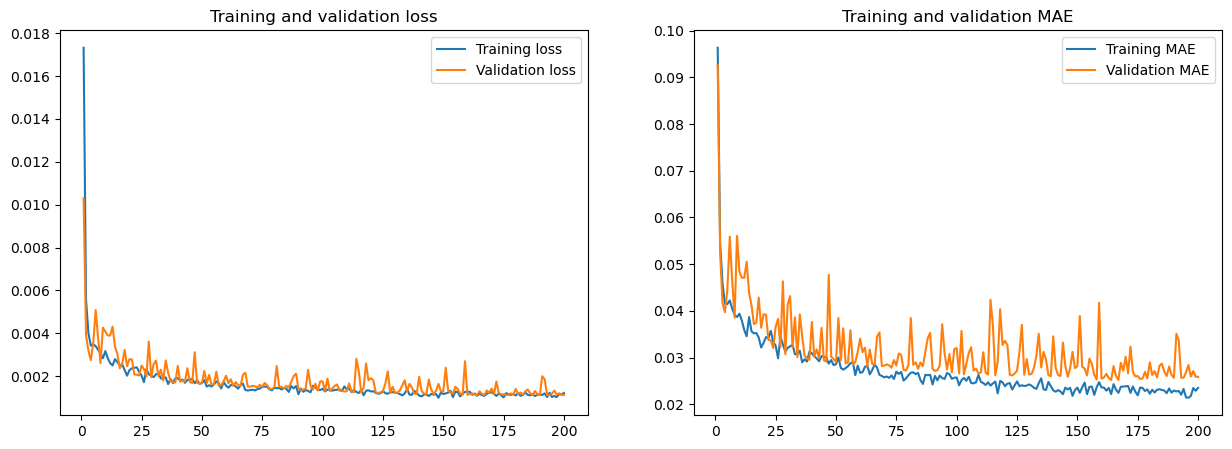

In [9]:
print(history.history.keys())

mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss,  label='Training loss')
plt.plot(epochs, val_loss,  label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, mae,  label='Training MAE')
plt.plot(epochs, val_mae,  label='Validation MAE')
plt.title('Training and validation MAE')
plt.legend()

#### Train Data 결과 예측 비교

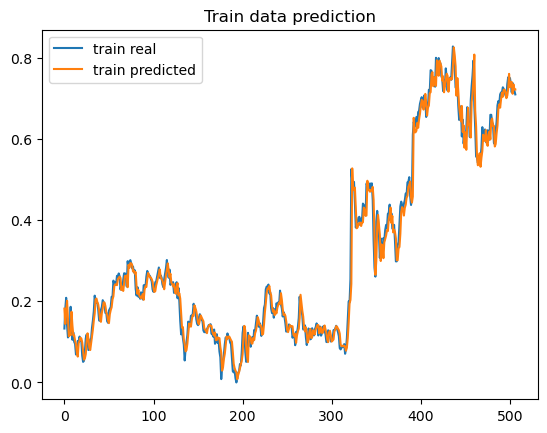

In [10]:
trainPredict = model.predict(X_train)

plt.plot(y_train, label="train real")
plt.plot(trainPredict, label="train predicted")
plt.title('Train data prediction')
plt.legend()

#### Test Data 결과 예측 비교

Text(0.5, 1.0, 'Test data prediction')

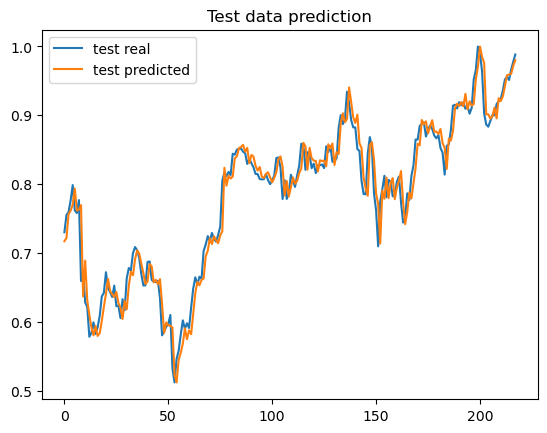

In [11]:
testPredict = model.predict(X_test)

plt.plot(y_test, label="test real")
plt.plot(testPredict, label="test predicted")
plt.legend()
plt.title('Test data prediction')

#### 평가

In [12]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 5ms/step - loss: 5.6750e-04 - mae: 0.0175


[0.0005675049033015966, 0.01748947985470295]

In [13]:
pred = model.predict(X_test[0:1])
print(pred, y_test[0])

# 역 스케일링
scaled = np.zeros((2,5))
scaled[0,-1] = y_test[0]
scaled[1,-1] = pred
scaler.inverse_transform(scaled)[:, -1]

[[0.71712726]] 0.7301802147545013


array([743.090027  , 738.61132783])

### Text 데이타 실습, One-hot Encoding


#### 입출력 데이타 준비

In [14]:
import tensorflow as tf
import numpy as np

sentence = "hihello"

voca = set(sentence) #unique charters
char2idx = {c:i for i,c in enumerate(voca)}
idx2char = {i:c for i, c in enumerate(voca)}
print(f'sentence:{sentence}')
print(f'char2idx:{char2idx}, idx2char:{idx2char}')

x = sentence[:-1] #"hihell"
y = sentence[1:] #"ihello"
print(f'x:{x}, y:{y}')

n_class = len(voca)  #example size
n_time_steps = len(x) #input sequence
hidden_size = n_class #output size

''' convert char to integer '''
x_idx = [char2idx[c] for c in x]
y_idx = [char2idx[c] for c in y]
print(f"x_idx:{x_idx}, y_idx:{y_idx}")

''' one-hot encoding'''
x_enc =tf.keras.utils.to_categorical(x_idx, num_classes=n_class)
x_enc = np.expand_dims(x_enc, axis=0)

y_enc = tf.keras.utils.to_categorical(y_idx, num_classes=n_class)
y_enc = np.expand_dims(y_enc, axis=0)
print("x_enc:", x_enc, x_enc.shape, )
print("y_enc:", y_enc, y_enc.shape)

sentence:hihello
char2idx:{'o': 0, 'i': 1, 'l': 2, 'h': 3, 'e': 4}, idx2char:{0: 'o', 1: 'i', 2: 'l', 3: 'h', 4: 'e'}
x:hihell, y:ihello
x_idx:[3, 1, 3, 4, 2, 2], y_idx:[1, 3, 4, 2, 2, 0]
x_enc: [[[0. 0. 0. 1. 0.]
  [0. 1. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 1. 0. 0.]
  [0. 0. 1. 0. 0.]]] (1, 6, 5)
y_enc: [[[0. 1. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 1. 0. 0.]
  [0. 0. 1. 0. 0.]
  [1. 0. 0. 0. 0.]]] (1, 6, 5)


#### LSTM을 이용한 모델 학습

In [15]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(hidden_size, input_shape=(n_time_steps, n_class), return_sequences=True))
model.add(tf.keras.layers.Dense(hidden_size))
model.add(tf.keras.layers.Activation('softmax'))
model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

n_epochs = 1000
history = model.fit(x_enc, np.reshape(y_idx, (1,6,1)), epochs=n_epochs, verbose=0)

preds = model.predict(x_enc)
print(preds, np.squeeze(np.argmax(preds, axis=2)))
print([idx2char[i] for i in np.squeeze(np.argmax(preds, axis=2))])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6, 5)              220       
_________________________________________________________________
dense_3 (Dense)              (None, 6, 5)              30        
_________________________________________________________________
activation (Activation)      (None, 6, 5)              0         
Total params: 250
Trainable params: 250
Non-trainable params: 0
_________________________________________________________________
[[[0.03063688 0.77372235 0.01328815 0.14027303 0.04207947]
  [0.01305695 0.10877884 0.01658397 0.6468197  0.2147605 ]
  [0.00880179 0.02236146 0.02423027 0.19781165 0.7467949 ]
  [0.00563361 0.00207456 0.9558885  0.01394119 0.02246212]
  [0.08145859 0.00246691 0.9073762  0.00211717 0.00658111]
  [0.86167306 0.02725603 0.09180399 0.00514161 0.01412535]]] [1 3 4 2 2 0]
['i', 'h', 'e', 

### Keras Embedding Layer 실습
* 긍정/부정 어휘 분류

In [16]:
import tensorflow as tf

corpus = ['very good nice quality', 
             'stop lies',
             'ugly terrible', 
             'excellent work', 
             'adorable lovely', 
             'bad',
             'greate nice']

y_train = [1, 0, 0, 1, 1, 0, 1] #1 :pos, 0 : neg

t = tf.keras.preprocessing.text.Tokenizer()
t.fit_on_texts(corpus)
vocab_size = len(t.word_index) + 1

print(f'vocab_size : {vocab_size}')

X_encoded = t.texts_to_sequences(corpus) # 문장을 단어의 인덱스 벡터로 변환
print(f'integer encoded: {X_encoded}')

max_len=max(len(l) for l in X_encoded)
print(f'max_len: {max_len}')

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_encoded, maxlen=max_len, padding='post')
y_train=np.array(y_train)
print(f'padded : {X_train}')

embd = tf.keras.layers.Embedding(vocab_size, 2, input_length=max_len)
print(f'embedding init : {embd(X_train)[:3]}')

model = tf.keras.Sequential()
model.add(embd) 
model.add(tf.keras.layers.Flatten()) # Dense의 입력으로 넣기위함.
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.fit(X_train, y_train, epochs=500, verbose=0)

print(f'embedding last : {embd(X_train)[:3]}')

vocab_size : 15
integer encoded: [[2, 3, 1, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13], [14, 1]]
max_len: 4
padded : [[ 2  3  1  4]
 [ 5  6  0  0]
 [ 7  8  0  0]
 [ 9 10  0  0]
 [11 12  0  0]
 [13  0  0  0]
 [14  1  0  0]]
embedding init : [[[-0.03387579  0.00945093]
  [ 0.04958024  0.01129835]
  [ 0.04722684 -0.04867446]
  [-0.03366282  0.03631841]]

 [[-0.03906244  0.03781896]
  [ 0.02580542 -0.03085631]
  [-0.04468893 -0.03107666]
  [-0.04468893 -0.03107666]]

 [[-0.00226939  0.03006324]
  [-0.02015979 -0.01573056]
  [-0.04468893 -0.03107666]
  [-0.04468893 -0.03107666]]]
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4, 2)              30        
_________________________________________________________________
flatten (Flatten)            (None, 8)                 0         
_________________________________________________________________

#### 벡터 시각화

[[-0.45409068  0.23030303]
 [ 0.6413329  -0.58399236]
 [ 0.35008687  0.37933207]
 [ 0.41882074 -0.553628  ]
 [ 0.33257344 -0.3134184 ]
 [-0.48746634 -0.3950432 ]
 [-0.40635216  0.5981489 ]
 [-0.4489047  -0.40104678]
 [-0.45056573  0.6117341 ]
 [ 0.45372224  0.480611  ]
 [ 0.4690191  -0.6878898 ]
 [ 0.4624608   0.45890492]
 [ 0.4260749  -0.68901837]
 [-0.45390213 -0.41522354]
 [ 0.46556425  0.5014453 ]]


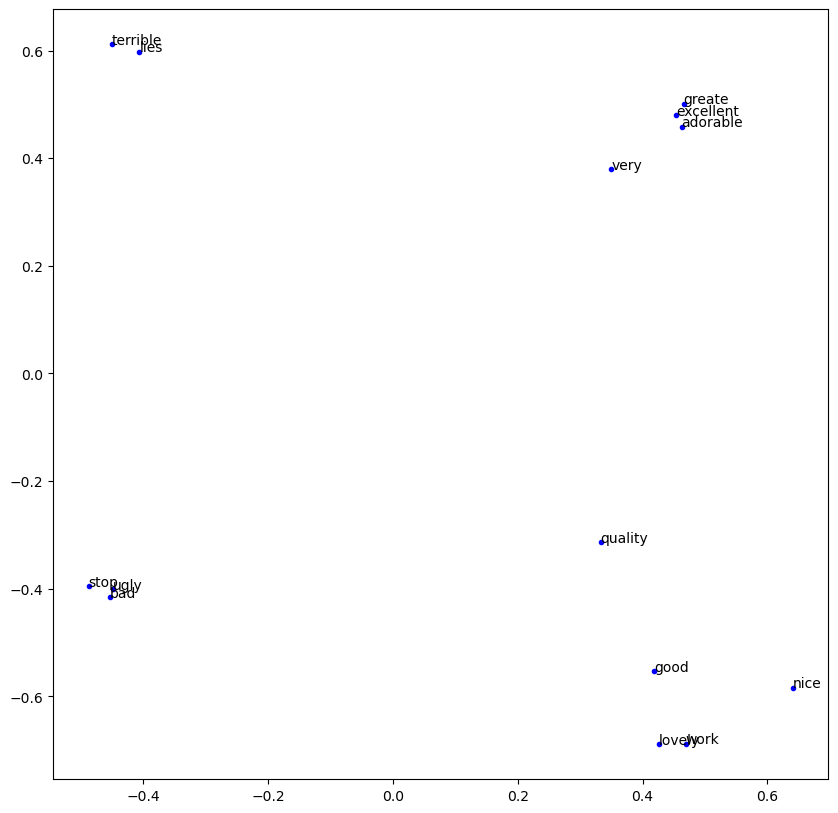

In [17]:
import matplotlib.pyplot as plt

embd_matrix = embd.get_weights()[0]
print(embd_matrix)
plt.figure(figsize=(10,10))  
for idx, (x1, x2) in enumerate(embd_matrix):
    if idx == 0 : continue
    plt.plot(x1, x2, 'b.')
    plt.annotate(t.index_word[idx], (x1,x2 ))

### Embeding Layer를 이용한 IMDB 텍스트 분류 실습


#### 데이타 준비

In [1]:
import tensorflow as tf

imdb = tf.keras.datasets.imdb

voca_size = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=voca_size)
print(f'train set : {len(X_train)}, test set: {len(X_test), }, classes : {max(y_train)+1}')

train set : 25000, test set: (25000,), classes : 2


#### 단어-인덱스 사전 생성

In [2]:
imdb_word_index = imdb.get_word_index()
imdb_index_word = { idx : key for key, idx in imdb_word_index.items()}

print(imdb_index_word[1], imdb_word_index['the'])

the 1


#### 데이타 미리보기

In [9]:
print(X_train[0][:20])

# 0:pad, 1:<start>, 2:UNK 
' '.join([imdb_index_word.get(i-3, '?') for i in X_train[0][:20]])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25]


"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you"

#### 패딩

In [10]:
#padding
max_len = 500
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

#### 모델 생성, 훈련, 평가

In [11]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(voca_size, 250))
model.add(tf.keras.layers.LSTM(120))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=64)

result = model.evaluate(X_test, y_test)
print(f'cost :{result[0]}, accuracy:{result[1] * 100:.2f}%')

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 39s 2ms/sample - loss: 0.4619 - acc: 0.7776 - val_loss: 0.4323 - val_acc: 0.7946
Epoch 2/20
25000/25000 [==============================] - 38s 2ms/sample - loss: 0.2810 - acc: 0.8888 - val_loss: 0.3118 - val_acc: 0.8688
Epoch 3/20
25000/25000 [==============================] - 39s 2ms/sample - loss: 0.1878 - acc: 0.9290 - val_loss: 0.3479 - val_acc: 0.8660
Epoch 4/20
25000/25000 [==============================] - 39s 2ms/sample - loss: 0.1432 - acc: 0.9474 - val_loss: 0.4493 - val_acc: 0.8605
Epoch 5/20
25000/25000 [==============================] - 40s 2ms/sample - loss: 0.1142 - acc: 0.9581 - val_loss: 0.3961 - val_acc: 0.8683
Epoch 6/20
25000/25000 [==============================] - 41s 2ms/sample - loss: 0.1072 - acc: 0.9613 - val_loss: 0.4287 - val_acc: 0.8546
Epoch 7/20
25000/25000 [==============================] - 41s 2ms/sample - loss: 0.0674 - acc: 0.9771 - val_loss: 0.